In [1]:
#7.4.1. Inception块
#在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。
#这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

#Inception块由四条并行路径组成。 
#前三条路径使用窗口大小为  1×1 、 3×3  和  5×5  的卷积层，
#从不同空间大小中提取信息。 
#中间的两条路径在输入上执行  1×1  卷积，以减少通道数，
#从而降低模型的复杂性。 
#第四条路径使用  3×3  最大池化层，然后使用  1×1  卷积层来改变通道数。 
#这四条路径都使用合适的填充来使输入与输出的高和宽一致，
#最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。
#在Inception块中，通常调整的超参数是每层输出通道的数量。
!pip install d2l
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # `c1`--`c4` 是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

     |████████████████████████████████| 81kB 5.5MB/s 


In [2]:
#7.4.2. GoogLeNet 模型
#GoogLeNet 一共使用 9 个Inception块和全局平均池化层的堆叠来生成其估计值。
#Inception块之间的最大池化层可降低维度。 
#第一个模块类似于 AlexNet 和 LeNet，Inception块的栈从VGG继承，全局平均池化层避免了在最后使用全连接层。
#现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用 64 个通道、  7×7  卷积层。
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

In [3]:
#第二个模块使用两个卷积层：第一个卷积层是 64个通道、  1×1  卷积层；第二个卷积层使用将通道数量增加三倍的  3×3  卷积层。 这对应于 Inception 块中的第二条路径。
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [7]:
#GoogLeNet 模型的计算复杂，而且不如 VGG 那样便于修改通道数。 
#为了在Fashion-MNIST上有一个合理的训练时间，我们将输入的高和宽从 224 降到 96，这简化了计算。下面演示各个模块输出的形状变化。
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.237, train acc 0.910, test acc 0.898
1351.2 examples/sec on cuda:0


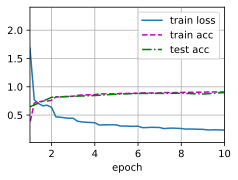

In [8]:
#7.4.3. 训练
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())